# Categorizing Movies by Title & Description Alone

In this notebook, we will be using the [Netflix Movies and TV Shows](https://www.kaggle.com/datasets/anandshaw2001/netflix-movies-and-tv-shows) from Kaggle
to categorize movies based on their title and description alone.

To do this, we will be using [Sentence Transformers](https://sbert.net/) to produce high-dimensional embeddings of movie descriptions,
and categorize them using k-means clustering. This library uses BERT style models which
are encoder-only transformer models. The embeddings created maintain a cosine similarity, and are geared towards
classification and sentiment analysis problems, so this should be perfect for k-means clustering.

We will seek to create 11 clusters, as that is generally considered the number of "super genres"
for movies. 

After creating these 11 clusters, we will do an analysis to see if we can produce a description for each cluster by hand,
and then do a comparative analysis against the originally provided categories to see how these clusters compare.

Perhaps the current system of categorizing movies is wrong. We will soon find out!

In [41]:
import pandas as pd

df = pd.read_csv("netflix_titles.csv")

display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


None

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

## EDA, Cleaning, and Transformation

We can see from the data above that we need to remove some stuff. We're only interested
in categorizing movies, and the provided categories will only be used for reference
in our analysis later. The dataset is provided with duplicates removed, so we don't
have to worry about deduplicating. We're also not interested in location, as all these
movies have english titles and descriptions, which will suit are needs perfectly.

So let's drop the colums we don't need, and let's filter for only the movies
as we don't care about shows. 

We will also parse the `listed_in` comma separated values into a real list
that will make operating on Pandas DataSets easier later on in our analysis.

We then show an example of our newly cleaned and condensed data set.

In [42]:
df = df[df.type == 'Movie'][['show_id', 'description', 'title', 'listed_in']]

df['listed_in'] = df['listed_in'].str.split(', ')

# change types
df = df.astype({
  'show_id': 'string',
  'description': 'string',
})

df = df.reset_index(drop=True)

display(df.info())
display(df.head())
display(df.listed_in[7])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      6131 non-null   string
 1   description  6131 non-null   string
 2   title        6131 non-null   object
 3   listed_in    6131 non-null   object
dtypes: object(2), string(2)
memory usage: 191.7+ KB


None

show_id                                        description  \
0      s1  As her father nears the end of his life, filmm...   
1      s7  Equestria's divided. But a bright-eyed hero be...   
2      s8  On a photo shoot in Ghana, an American model s...   
3     s10  A woman adjusting to life after a loss contend...   
4     s13  After most of her family is murdered in a terr...   

                              title  \
0              Dick Johnson Is Dead   
1  My Little Pony: A New Generation   
2                           Sankofa   
3                      The Starling   
4                      Je Suis Karl   

                                           listed_in  
0                                    [Documentaries]  
1                         [Children & Family Movies]  
2  [Dramas, Independent Movies, International Mov...  
3                                 [Comedies, Dramas]  
4                     [Dramas, International Movies]

['Thrillers']

We also want to get a sense for how many movies that are in each category. Several
categories have a pretty large representation, and can describe characteristics
of the movie that aren't necessarily related to the category.

We'll also keep a copy of this data as a dictionary we'll use later on in our analysis.

listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Horror Movies                357
Stand-Up Comedy              343
Sci-Fi & Fantasy             243
Sports Movies                219
Classic Movies               116
LGBTQ Movies                 102
Anime Features                71
Cult Movies                   71
Faith & Spirituality          65
Movies                        57
Name: count, dtype: int64

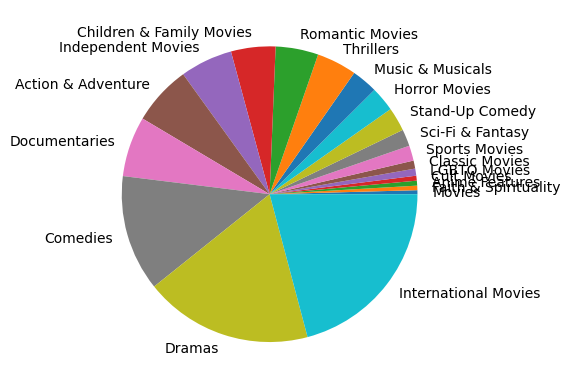

In [74]:
import matplotlib.pyplot as plt

cat_counts = df.listed_in.explode().value_counts()
display(cat_counts)
cat_counts = cat_counts.to_dict()

cat_items: list = list(cat_counts.items())
cat_items.sort(key=lambda x: x[1])
cats, counts = list(zip(*cat_items))
plt.pie(counts, labels = cats)
plt.show() 

Next, we will use the [Sentence Transformers](https://sbert.net/) library to produce
high-dimensional latent representations of the text. This library uses encoder-only models
(similar to BERT) that are very useful for doing many types of text analysis. When comparing
to the original [Transformers paper](https://arxiv.org/abs/1706.03762) this model represents just
the first part of the model that would normally be used by the decoder to provide context
from the original input text. This is usually important in translation tasks, but here
we're only interested in the context part of the data.

The Sentence Transformers library has several models that are fine-tuned on just this type
of task, and better yet, are fine-tuned to provide cosine similarity for thier latent representations.
This property is important for classification tasks, but is also very useful for clustering tasks
as the subject matter or context of the text tends to form "close distance" relationships for similar
contexts across its high dimensional space.

We load the library, and a pre-trained model, then show an example of this latent text relationship.
The vector space spans 384 dimensions, which creates a very large feature space to cluster over.

In [69]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
vec = model.encode("This is a test sentence.")
print(vec.shape)
vec

(384,)


array([ 8.42964575e-02,  5.79537079e-02,  4.49339300e-03,  1.05821110e-01,
        7.08340760e-03, -1.78446583e-02, -1.68880653e-02, -1.52282761e-02,
        4.04730849e-02,  3.34225520e-02,  1.04327634e-01, -4.70358171e-02,
        6.88473182e-03,  4.10179570e-02,  1.87120028e-02, -4.14923094e-02,
        2.36473810e-02, -5.65018542e-02, -3.36962044e-02,  5.09909801e-02,
        6.93032071e-02,  5.47841713e-02, -9.78842750e-03,  2.36971844e-02,
        1.99966263e-02,  9.71734338e-03, -5.88991232e-02,  7.30735762e-03,
        4.70265225e-02, -4.51007020e-03, -5.57997562e-02, -4.15945472e-03,
        6.47570491e-02,  4.80762869e-02,  1.70208178e-02, -3.18334461e-03,
        5.74023724e-02,  3.52318473e-02, -5.88395540e-03,  1.48329195e-02,
        1.15763107e-02, -1.07480690e-01,  1.91042051e-02,  2.20857151e-02,
        1.08645195e-02,  3.78192822e-03, -3.19403335e-02,  1.07278330e-02,
       -4.84227994e-03, -2.83362456e-02, -5.25735393e-02, -7.05867708e-02,
       -5.75558990e-02, -

We then prepare the text sample that we will feed into the model. We use the
title of the movie (prepended with "Title:") followed by some new lines, and the 
description. These transformer models have been trained on a large corpus of internet
text, and are therefor pretty good at understanding formatting. Formatting the text this way 
presents it more like a synposis, or short story, allowing the title to stand on its own
and not be interpreted as part of the description.

In [ ]:
combined_text = 'Title: ' + df.title + '\n\n' + df.description
display(combined_text)

df['embeddings'] = combined_text.map(model.encode)

df.head()

0       Title: Dick Johnson Is Dead

As her father nea...
1       Title: My Little Pony: A New Generation

Eques...
2       Title: Sankofa

On a photo shoot in Ghana, an ...
3       Title: The Starling

A woman adjusting to life...
4       Title: Je Suis Karl

After most of her family ...
                              ...                        
6126    Title: Zinzana

Recovering alcoholic Talal wak...
6127    Title: Zodiac

A political cartoonist, a crime...
6128    Title: Zombieland

Looking to survive in a wor...
6129    Title: Zoom

Dragged from civilian life, a for...
6130    Title: Zubaan

A scrappy but poor boy worms hi...
Length: 6131, dtype: string

show_id                                        description  \
0      s1  As her father nears the end of his life, filmm...   
1      s7  Equestria's divided. But a bright-eyed hero be...   
2      s8  On a photo shoot in Ghana, an American model s...   
3     s10  A woman adjusting to life after a loss contend...   
4     s13  After most of her family is murdered in a terr...   

                              title  \
0              Dick Johnson Is Dead   
1  My Little Pony: A New Generation   
2                           Sankofa   
3                      The Starling   
4                      Je Suis Karl   

                                           listed_in  \
0                                    [Documentaries]   
1                         [Children & Family Movies]   
2  [Dramas, Independent Movies, International Mov...   
3                                 [Comedies, Dramas]   
4                     [Dramas, International Movies]   

                                          embeddings  
0  [-0.10847272, -0.05420203, -0.050003912, -0.04...  
1  [0.044760883, 0.0011431428, 0.074306205, -0.02...  
2  [-0.058361128, 0.035035975, -0.0026323325, 0.0...  
3  [-0.0028718768, -0.0042604804, 0.021970626, 0....  
4  [-0.038821094, 0.10661764, -0.046585407, 0.002...

## Text Corpus Analysis

Let's print a word cloud from our bodies of text.

Right away, we can get a sense of how the words in the titles and descriptions will
lead to the categories. We will be using a transformer model for this task which
will look at the entire context of the text, but we can see a few things that might 
become large factors:
* Gender: there are many gendered words present.
* Subject: family, world, life, love, home.
* Action: make, live, find, dream, begin.

It will be fascinating to see what deep-meaning clusters we'll get from the analysis.
But let's not read into it too much. We know what kind of data we're working with here:
language. We'll need to rely on our Transformer's deep latent represntations to find
the real meaning here.

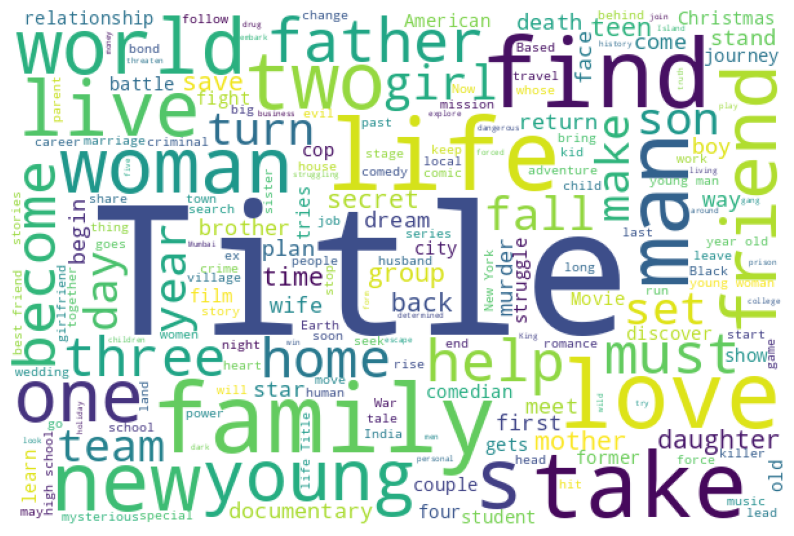

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, height=400, background_color='white')
wordcloud.generate(' '.join(combined_text.to_list()))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Clustering

Now that our data is good to go, let's create a k-means cluster model
to process these large latent vectors, and we will assign the cluster results
to the data frame for later analysis.

In [71]:
from sklearn.cluster import KMeans
import numpy as np

data = np.stack(df.embeddings)

cluster = KMeans(11, random_state=123123)
cluster.fit(data)

res = cluster.predict(data)

df['cluster'] = res

df.head()

show_id                                        description  \
0      s1  As her father nears the end of his life, filmm...   
1      s7  Equestria's divided. But a bright-eyed hero be...   
2      s8  On a photo shoot in Ghana, an American model s...   
3     s10  A woman adjusting to life after a loss contend...   
4     s13  After most of her family is murdered in a terr...   

                              title  \
0              Dick Johnson Is Dead   
1  My Little Pony: A New Generation   
2                           Sankofa   
3                      The Starling   
4                      Je Suis Karl   

                                           listed_in  \
0                                    [Documentaries]   
1                         [Children & Family Movies]   
2  [Dramas, Independent Movies, International Mov...   
3                                 [Comedies, Dramas]   
4                     [Dramas, International Movies]   

                                          embeddings  cluster  
0  [-0.10847272, -0.05420203, -0.050003912, -0.04...        3  
1  [0.044760883, 0.0011431428, 0.074306205, -0.02...        1  
2  [-0.058361128, 0.035035975, -0.0026323325, 0.0...        0  
3  [-0.0028718768, -0.0042604804, 0.021970626, 0....        7  
4  [-0.038821094, 0.10661764, -0.046585407, 0.002...        3

### Category Analysis

Our first round of analysis will be based on the representation of certain categories
in each cluster. We use our category count map we created earlier to normalize the movie
counts for each category so we can visualize the categories in each cluster as percentage 
of total movies in that category.

We also remove the category "Movie", as that's not really helpful to us here.

Let's go through each cluster and show a pie graph of the "percentage of total"
for each category in the cluster.

Cluster:  0


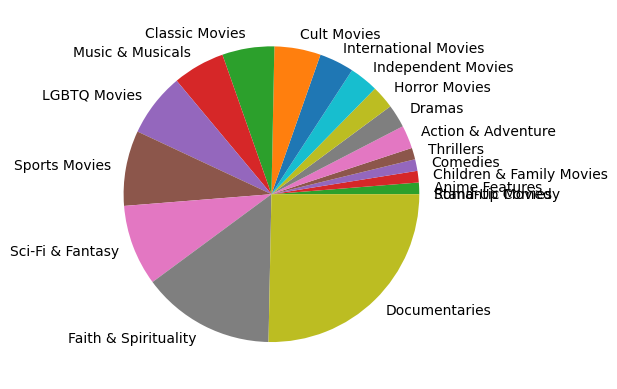

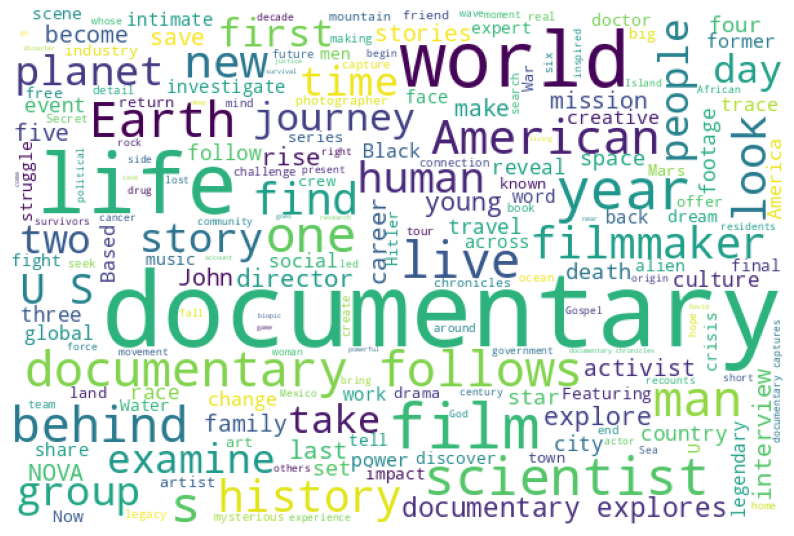

Cluster:  1


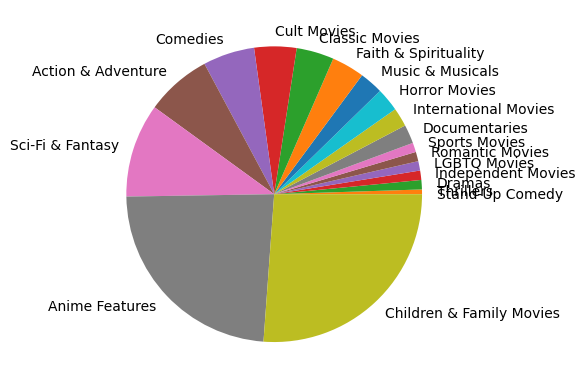

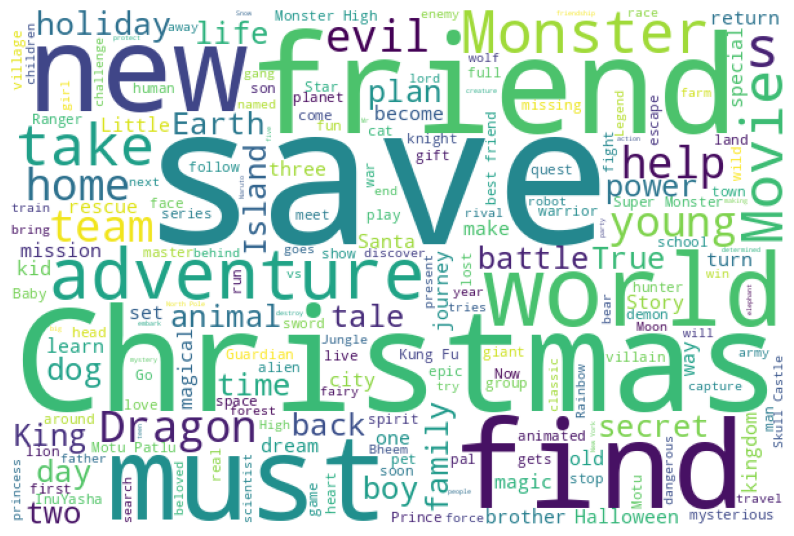

Cluster:  2


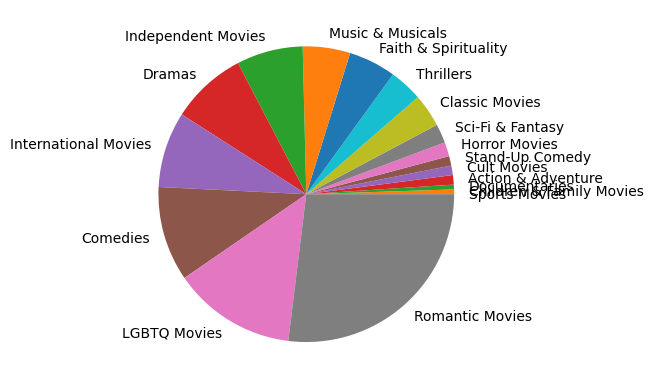

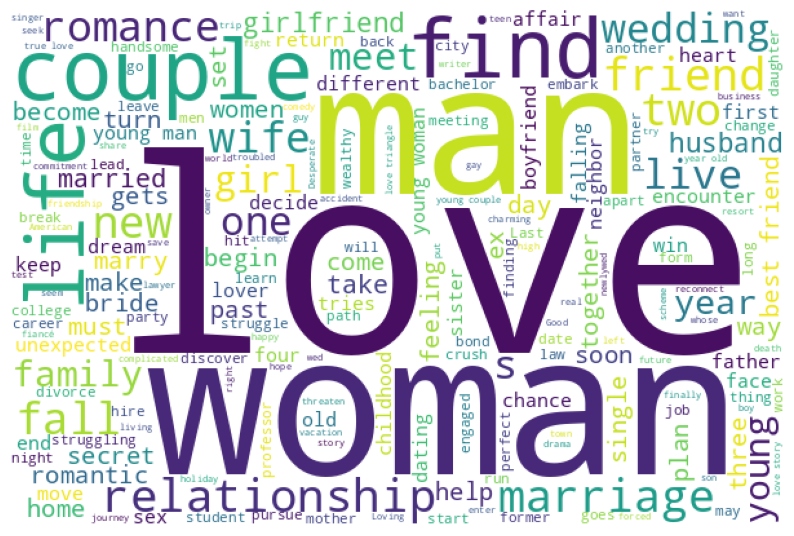

Cluster:  3


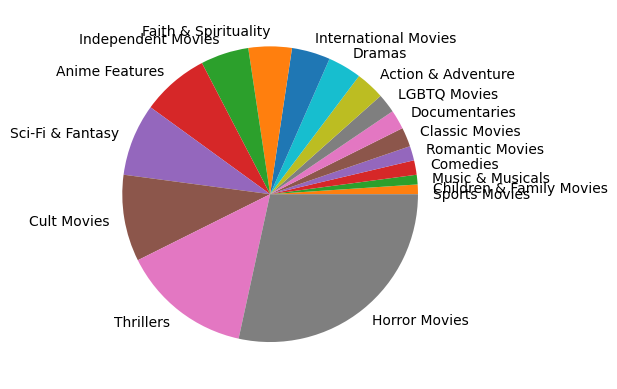

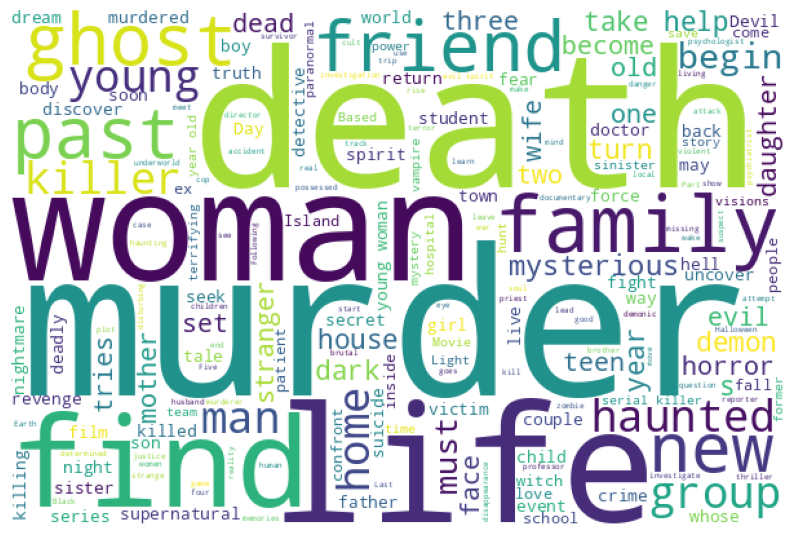

Cluster:  4


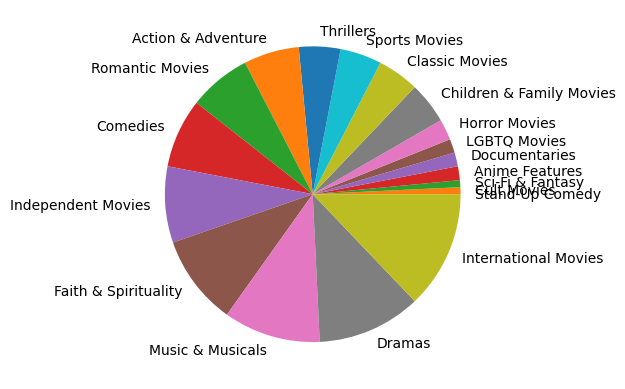

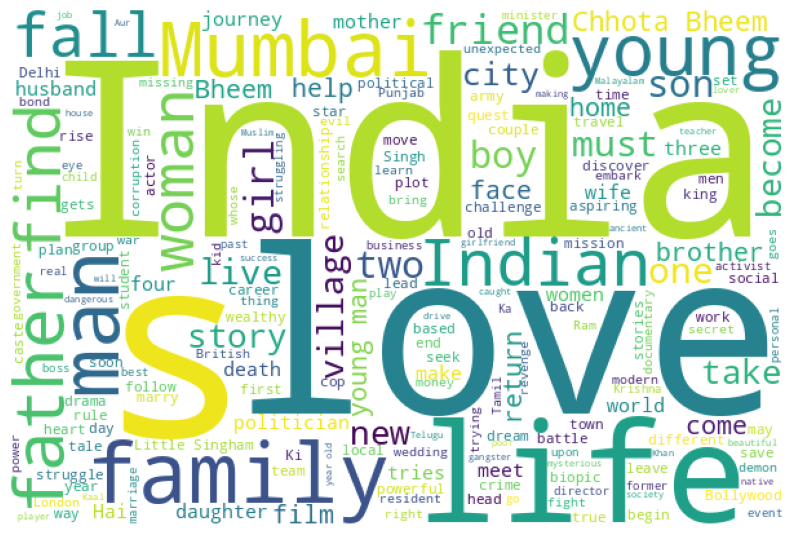

Cluster:  5


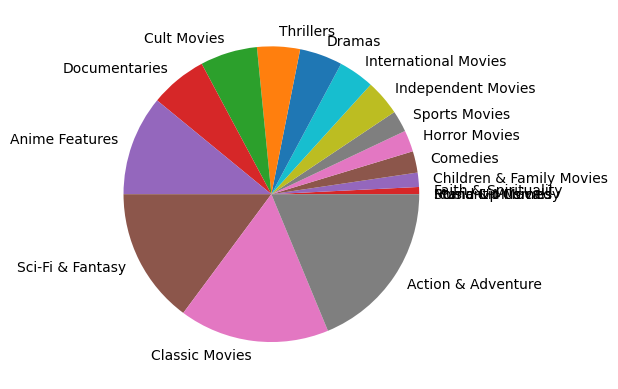

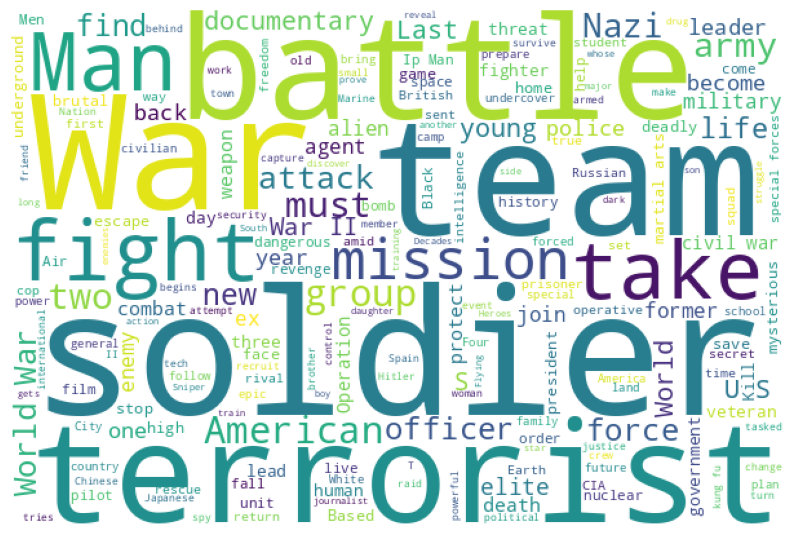

Cluster:  6


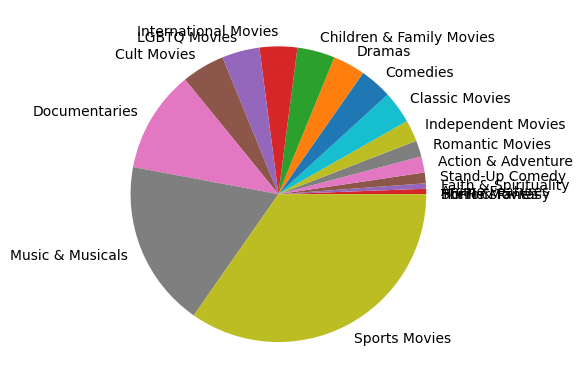

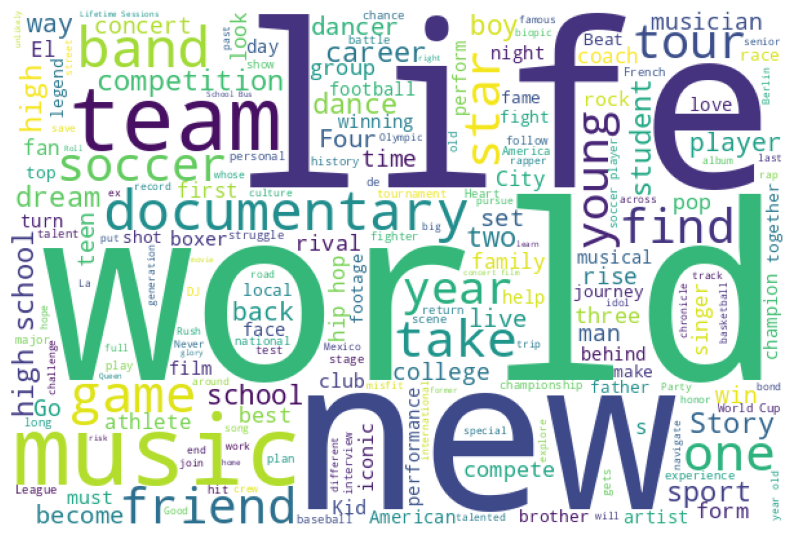

Cluster:  7


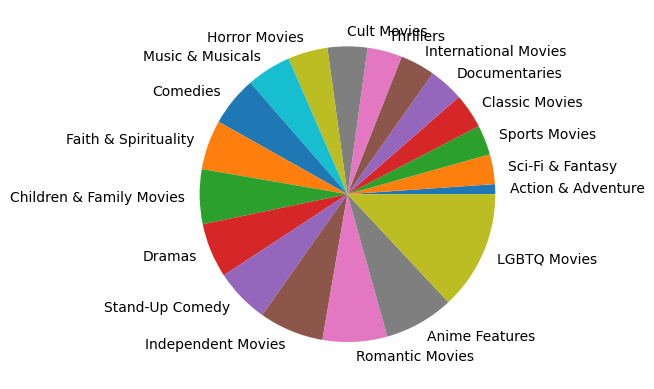

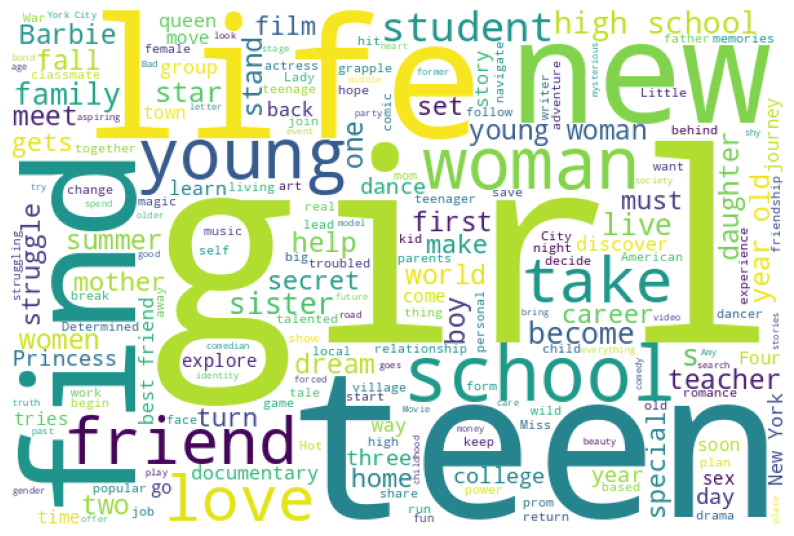

Cluster:  8


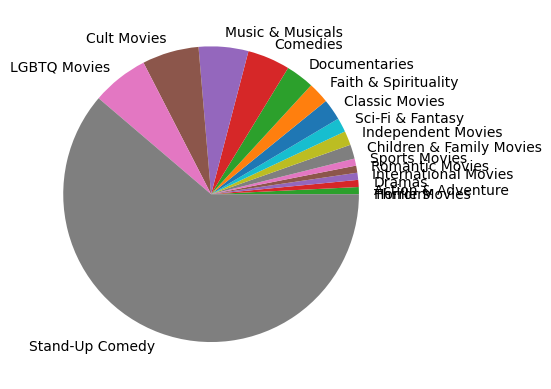

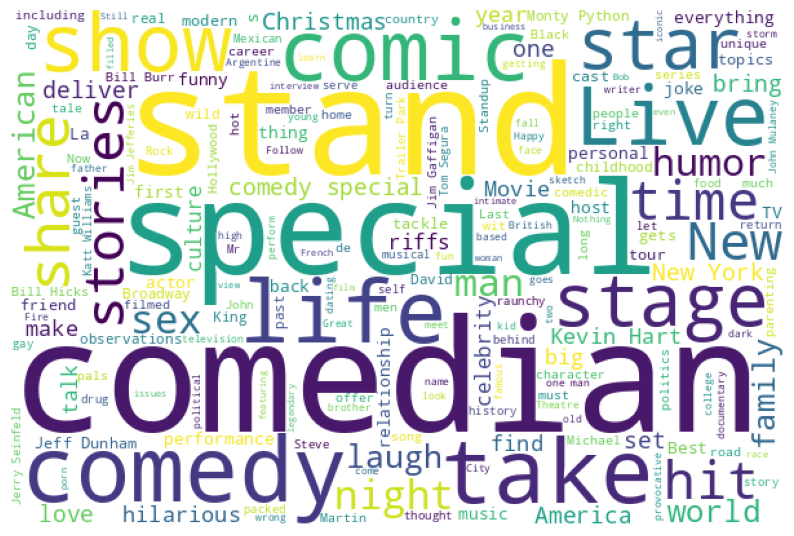

Cluster:  9


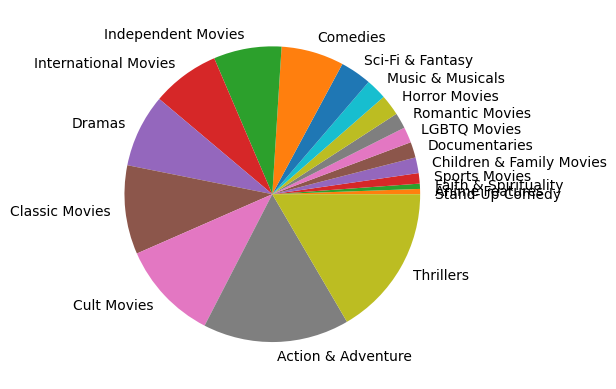

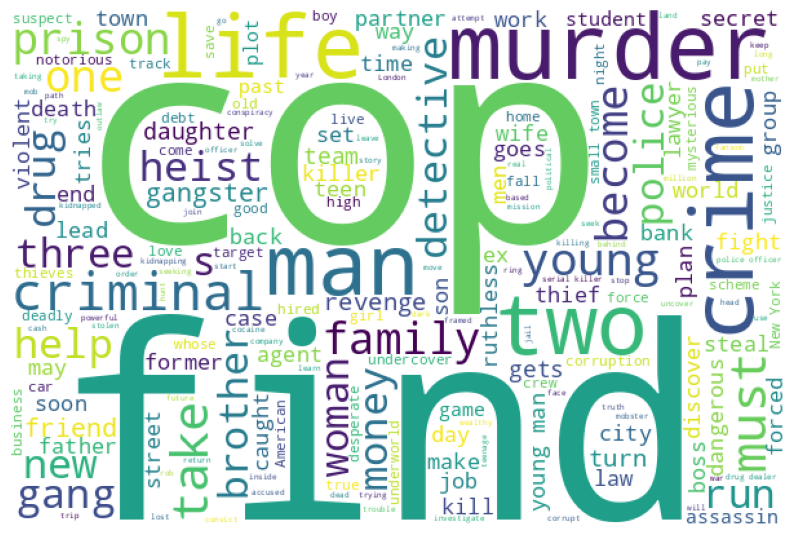

Cluster:  10


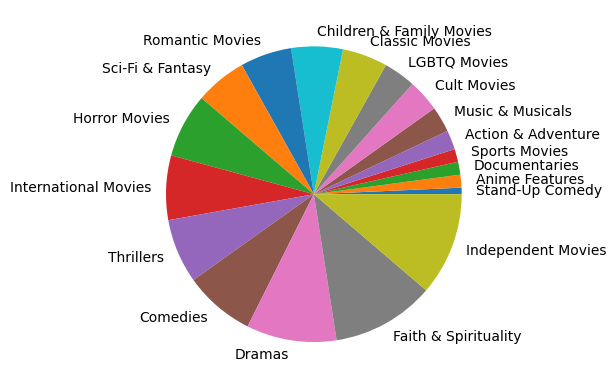

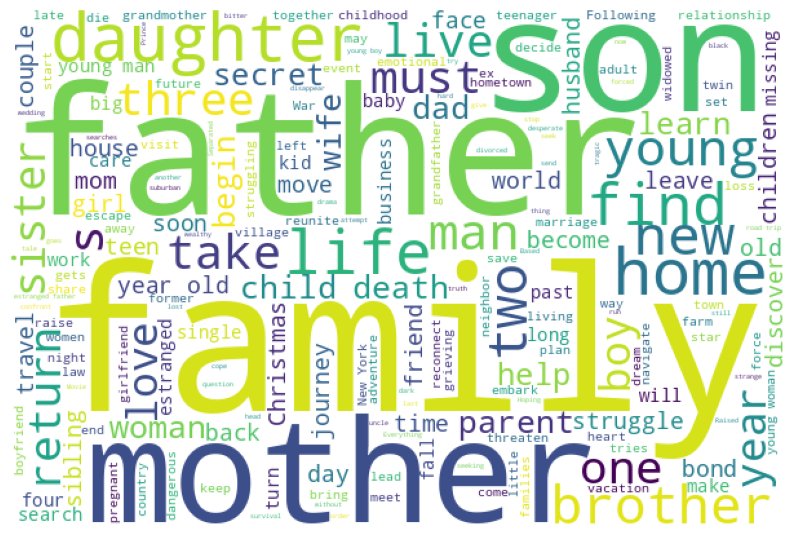

In [76]:
grp = ['cluster', 'listed_in']
res = df[grp].explode("listed_in").groupby(grp)['cluster'].count()

res = res.sort_values(ascending=False, kind='stable').sort_index(kind='stable')

out = dict()

for (cluster, cat), count in res.items():
  if cluster not in out:
    out[cluster] = list()
  pct = count / cat_counts[cat]
  if cat != 'Movies':
    out[cluster].append((cat, int(pct*100)))

for cluster, data in out.items():
  print('Cluster: ', cluster)
  data.sort(key=lambda item: item[1])
  cats, pcts = list(zip(*data))
  plt.pie(pcts, labels = cats)
  plt.show()

  df_c = df[df.cluster == cluster]
  combined_text = df_c.title + '\n\n' + df_c.description
  wordcloud = WordCloud(width=600, height=400, background_color='white')
  wordcloud.generate(' '.join(combined_text.to_list()))

  plt.figure(figsize=(10,15))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()


## Cluster Analysis

Each cluster definitely seems to have its own identity. Let's characterise a few of them based on the makeup of the categories they include:
* Cluster 0: *Needs more analysis*
* Cluster 1: This is mostly kids movies and family movies.
* Cluster 2: Stories about love!
* Cluster 3: Culty horror thrillers.
* Cluster 4: *Needs more analysis*
* Cluster 5: Movies about war.
* Cluster 6: *Needs more analysis*
* Cluster 7: *Needs more analysis*
* Cluster 8: Stand-up comedy. Easy.
* Cluster 9: Movies about crime, criminals, police.
* Cluster 10: Movies about family and home.

A few of these are head-scratchers. We'll do a deep dive on the actual text content
of those to figure out what those clusters represent.

### Cluster 0 Analysis

This was a little hard to tell from the category breakdown, but this is ultimately
just documentaries or documentary-like movies that cover: geo politics, nature, science,
war, and other hard-hitting real world topics. But mostly just documentaries. 

One interesting note comes from the use of the word "film" in the description.
This category also largely includes anything that would describe this as a "film"
instead of a "movie".

In [66]:
for x in df[df.cluster == 0].description.sample(n=10):
  print(x)

This documentary on actress and television producer Betty White traces her decades-long career as a  woman breaking new ground in entertainment.
This documentary explores the connections between elite athletes and Marvel superheroes such as Spider Man, Black Widow and Captain America.
This documentary takes a hard look at how indigenous peoples clashed violently with the Peruvian government over land and economics in the Amazon.
With the world's economy in dire straits, corporate protagonist Dagny Taggart searches for a solution amid the rubble of a long-abandoned factory.
Powerlifter Matt Kroczaleski faced his greatest challenge when he came out as transgender. This documentary captures his transition into a woman.
Follow scientists on their quest to understand and capture the first image of a black hole while exploring the limits of our knowledge of the universe.
Two adventurous pilots attempt to fly around the world without using any fuel, relying only on the power of the sun.
Accor

### Cluster 4 Analysis

Apparently, these are mostly movies with an eastern theme or location (especially India). Interesting. The movies
cover a wide range of genres, but given that "International Movies" is the largest representation here,
it makes sense.

In [55]:
for x in df[df.cluster == 4].description.sample(n=10):
  print(x)

When the village's biryani cook unexpectedly passes, a widow steps up to the plate and takes on new delectable challenges.
Shinda loves Laali but can't have her, so he and his friends come up with an elaborate plan to solve all their problems and win her.
A man buys a young girl, code-names her "Doll" and sends her to live with a mother of two who has a mysterious mission to be fulfilled.
A pugilist from Shantung struggles to rise to the top of the Shanghai triad ladder, where his stellar martial arts talents can shine.
An evil demon who traded his freedom for immortality lures Chhota Bheem and his friends to the city of Sonapur with tales of hidden treasure.
In this Bollywood drama, a corporate go-getter sees his priorities shift when personal tragedy brings him face-to-face with political corruption.
A nobleman who values his people's well-being over his emperor's edicts is killed. His knights vow revenge.
Orphaned and at loose ends, young Mukesh falls into the seductive orbit of mar

### Cluster 6 Analysis

Ah! This one makes sense now. These are movies about human movement! This includes sports, music, and dance. 
I don't think there are people that interested in the broad category of "movies about movement", but the
transformer model used for this task doesn't know what we're trying to achieve here.

In [56]:
for x in df[df.cluster == 6].description.sample(n=10):
  print(x)

A self-described outsider is sent to a rugby-obsessed boarding school, where he forms an unexpected bond with the star player.
Convinced Mexico will lose the World Cup qualifier without him, a soccer superfan faces an impossible choice when family obligations stand in his way.
Two huge soccer fans must go on a rambunctious road trip to fix a big match between Malaysia and Thailand, or they'll draw the ire of a loan shark.
By day, an 18-year-old delivers tofu for his father, a retired race car driver; but by night, it's the teen's turn to take the wheel.
After 15 years in France, Kamal returns to his native Beirut and reassembles his dance crew, striving to modernize traditional Dabke routines.
After being accused of cheating on a reality TV show, a dance troupe seeks to redeem itself by winning the World Hip-Hop Dance Championship.
Juggling personal predicaments and workplace woes, three buddies and bandmates practice for their ultimate dream: winning a coveted music competition.
Cast 

### Cluster 7 Analysis

This was a hard one to figure out, but it's ultimately all about the lives and adventures of women. This is a pretty interesting
cluster, as the descriptions must focus more on the female characters. This could just be due to the language used in the descriptions,
or it may be that there really isn't a category for "movies about women", but regardless the language fits them more into their own cluster
than that of the genres of the movie. 

In [63]:
for x in df[df.cluster == 7].description.sample(n=15):
  print(x)

In 1950s Harlem, three singing sisters hit the big time and end up losing one another in this musical melodrama inspired by the Supremes.
During World War II, daredevil star Miss Julia entertains soldiers at the Indo-Burma border, where she's caught up in a web of love and deceit.
Short on sense but long on self-confidence, dotty Deliha sets her sights on a hunky photographer who opens up shop in her neighborhood.
When dazzling L.A. sorority girl Elle Woods gets dumped by her snobby boyfriend, she decides to win him back by following him to Harvard Law School.
A group of 20-somethings in a small town experience a variety of personal and relationship issues leading up to a gathering at the local watering hole.
The actress, comedian and YouTube sensation riffs on everything from nail salons and Gypsies to Mexican moms and super-sleuthing Liam Neeson.
An intrepid high schooler in Sacramento undergoes the trials of love, family and self-discovery as she dreams of escaping to college on the

## Conclusion

This was a very fascinating project to do. We've show that the descriptions and titles of movies alone can
be good enough to figure out the category of movie it is, and that we can use the amazing power of transformers
to extract high-dimensional representations of the text for use in k-means clustering. We've also highlited
some potential issues with how we categorize movies. We don't offer a category for movies about women. And we don't
consider human movement to be an over-arching category (there are likely plenty of people that like sports and dance).
But for the most part, we've discovered that movies are categorized in a pretty effective way, as evident by the
analysis of the breakdown of prescribed categories in each cluster.

### Discussion and Future Work

For future work, I would be interested in seeing if there's a way to prime the input text a bit more to allow
the transformer model to produce a more task-specific set of latent vectors that may better suit this task. Also:

* I would be fascinated to see if there is any research or science behind the way we categorize movies. It seems kind of random.
* Is there any way to further fine-tune a transformer model to do better with this task?
* K-Means clustering suffers from many reproducibility problems. I wonder if NMF would work for this task.